In [9]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [10]:
import numpy as np
import pandas as pd

In [11]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [12]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
#added "inspect" function from sqlalchemy
from sqlalchemy import create_engine, func, inspect

In [13]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [14]:
# reflect an existing database into a new model
base = automap_base()
# reflect the tables
base.prepare(engine, reflect = True)

In [15]:
# We can view all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [16]:
# Save references to each table
meas = base.classes.measurement
station = base.classes.station

In [17]:
# Create our session (link) from Python to the DB
sess = Session(engine)

#Create inspector (pulled inspect function from sqlalchemy)
inspector = inspect(engine)

#Get columns from measurement
columns = inspector.get_columns('measurement')

#Create loop that shows column name and type
for x in columns:
    print(x['name'], ['type'])

id ['type']
station ['type']
date ['type']
prcp ['type']
tobs ['type']


In [18]:
#Display first 5 from measurement
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [19]:
#Get columns from station
columns = inspector.get_columns('station')

#loop to display columns in station
for x in columns:
    print(x['name'], x['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [20]:
#Display station
engine.execute('SELECT * FROM station').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

# Exploratory Climate Analysis

In [21]:
#Use query to find the last date
last_datapoint = sess.query(meas.date).order_by(meas.date.desc()).first()

#Print the last date
last_datapoint

('2017-08-23')

In [22]:
#define years
days_in_year = 365

#find date a year ago
last_year = dt.date(2017,8,23) - dt.timedelta(days = days_in_year)

#display date year ago
print(last_year)

2016-08-23


In [23]:
#query of last 12 months
rain_year = sess.query(meas.date,meas.prcp).filter(meas.date > last_year).all()

In [24]:
#Save query results as a Pandas Dataframe
df = pd.DataFrame(rain_year, columns=['Date', 'Precipitation'])

#Sort by date
df.set_index('Date', inplace=True)
df_sorted = df.sort_values('Date')

#Display Dataframe
df_sorted.head(10)

,Precipitation
Date,
2016-08-24,0.08
2016-08-24,NaN
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15
2016-08-24,1.45
2016-08-24,1.22
2016-08-25,0.08
2016-08-25,0.00


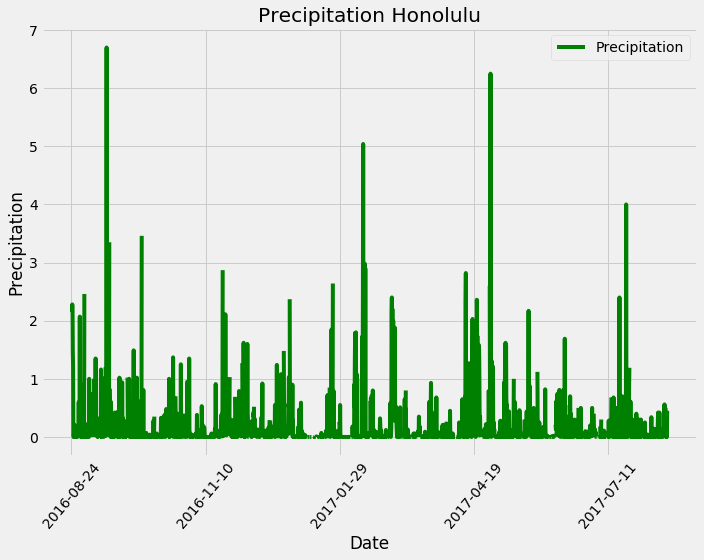

In [25]:
#Plot using Pandas and MatPlotLib

#Create plot
plot1 = df_sorted.plot(figsize = (10, 8),color='green')

#Get figure
fig = plot1.get_figure()

#Configure Graph
plt.title("Precipitation Honolulu")
plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.legend(["Precipitation"], loc = "best")
plt.xticks(rotation=50)

#Fix layout
plt.tight_layout()

#Save plot as an image
plt.savefig('Images/precipitation.png')

#Show Plot
plt.show()

In [26]:
# Use Pandas to calcualte the summary statistics for the precipitation data

#Use .describe() to summarize stats
summary_stats = df_sorted.describe()

#Display summary stats
summary_stats

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [27]:
# Design a query to show how many stations are available in this dataset?

sess.query(meas.station).distinct().count()

9

In [28]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

#Create a query to list most active stations
active_stations = sess.query(meas.station, func.count(meas.station)).\
    group_by(meas.station).\
    order_by(func.count(meas.station).desc()).all()

#Display list
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [29]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

#Create a query to find lowest, highest, and average
lha_temp = sess.query(func.min(meas.tobs),func.max(meas.tobs),func.avg(meas.tobs)).\
    filter(meas.station == 'USC00519281').order_by(func.min(meas.tobs)).all()

#Display results
print("Lowest, highest, and average:")
lha_temp

Lowest, highest, and average:


[(54.0, 85.0, 71.66378066378067)]

In [30]:
# Choose the station with the highest number of temperature observations.

#Use query to get station data
highest_temp_obs = sess.query(meas.tobs).\
    filter(meas.date >= last_year, meas.station == 'USC00519281').\
    order_by(meas.tobs).all()

#Convert into a DataFrame
highest_temp_obs_df = pd.DataFrame(highest_temp_obs, columns = ['Tobs'])

#Display
highest_temp_obs_df.head()

,Tobs
0,59.0
1,59.0
2,59.0
3,60.0
4,60.0


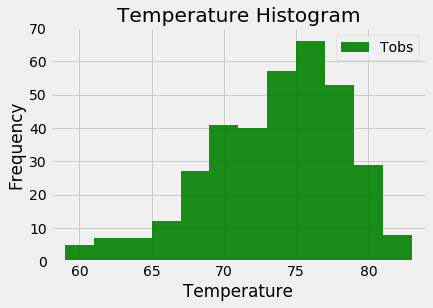

In [31]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

#Make the histogram plot
highest_temp_obs_df.plot.hist(highest_temp_obs, 12, facecolor = 'green', alpha = 0.9)

#configure plot
plt.ylim(0,70)
plt.xlim(58,84)
plt.title('Temperature Histogram')
plt.xlabel('Temperature')

#save plot as image
plt.savefig('Images/histogram.png')